In [1]:
import sys
# import sounddevice as sd
import soundfile as sf
import numpy as np
from scipy.signal import butter, filtfilt, spectrogram, find_peaks, savgol_filter
%matplotlib widget
import matplotlib.pyplot as plt
import time

from scipy.fft import fft, fftfreq

from tqdm import tqdm, trange



In [2]:
duration = 10  # Duration of recording in seconds (slightly longer than the actual broadcast)
fs = 44000  # Sampling frequency

bps = 50 # bits per secondes
bit_duration = 1/bps  # Duration of each bit in seconds
cutoff_low = 18000
cutoff_high = 22000
f1 = 21000
f0 = 19000

In [3]:
def bandpass_filter(data, cutoff_low, cutoff_high, fs):
    # Function to design a bandpass filter
    nyquist = 0.5 * fs
    low = cutoff_low / nyquist
    high = cutoff_high / nyquist
    b, a = butter(N=4, Wn=[low, high], btype='bandpass')
    return filtfilt(b, a, data)

In [4]:
# Function to encode data as an audio signal
def encode_data(data, bit_duration, fs, f1, f0):
    signal = np.array([])
    for bit in data:
        if bit == 1:
            bit_tone = create_tone(f1, bit_duration, fs)
        else:
            bit_tone = create_tone(f0, bit_duration, fs)
        signal = np.concatenate((signal, bit_tone))
    return signal

# Function to create a sine wave for a given frequency
def create_tone(freq, duration, fs):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    tone = 0.5 * np.sin(2 * np.pi * freq * t)
    return tone

In [5]:

def fft_cross_correlation(x, y):
    N = len(x) + len(y) - 1
    X = np.fft.fft(x, N)
    Y = np.fft.fft(y, N)
    corr = np.fft.ifft(X * np.conj(Y))
    return np.abs(corr)

def detect_signal_edge(threshold,signal, preamble_bits, fs,bit_duration, high,low,flip = False):
    preamble = encode_data(preamble_bits,bit_duration,fs,high,low)
    
    # Cross-correlation using FFT
    corr = fft_cross_correlation(signal,preamble)
    peaks, _ = find_peaks(corr, height=np.max(corr) * 0.5)
    if flip:
        index = np.argmax(np.flip(corr)>threshold)
        return len(signal)-index , corr
    index = np.argmax(corr > threshold)  # Take the first peak
    return index ,corr

In [12]:
filename = "test_50bps_shaviv.wav"
data, fs = sf.read(filename)
elapsed_time = len(data) / fs

In [13]:
threshold = 10
filtered_data = bandpass_filter(data, cutoff_low, cutoff_high, fs)
start_preamble_bits = [1,0,1,0,1]
end_preamble_bits = [0,0,0,0]
start_idx,start_corr = detect_signal_edge(threshold, filtered_data, start_preamble_bits, fs, bit_duration, f1, f0)
end_idx,end_corr = detect_signal_edge(threshold, filtered_data, end_preamble_bits, fs, bit_duration, f1, f0,True)

In [14]:
def normalize_signal(signal, sample_rate, freq1, freq2):
    # Perform FFT
    N = len(signal)
    fft_result = fft(signal)
    fft_freq = fftfreq(N, 1/sample_rate)
    
    # Get the amplitude of the signal at freq1 and freq2
    idx_freq1 = np.where(np.isclose(fft_freq, freq1, atol=1))[0][0]
    idx_freq2 = np.where(np.isclose(fft_freq, freq2, atol=1))[0][0]
    
    amplitude_freq1 = np.abs(fft_result[idx_freq1])
    amplitude_freq2 = np.abs(fft_result[idx_freq2])
    
    # Calculate the mean amplitudes
    mean_amplitude_freq1 = np.mean(amplitude_freq1)
    mean_amplitude_freq2 = np.mean(amplitude_freq2)
    
    # Normalize the signal
    normalized_signal = signal / max(mean_amplitude_freq1, mean_amplitude_freq2)
    
    return normalized_signal, mean_amplitude_freq1, mean_amplitude_freq2

In [9]:

(sig,mf0,mf1) = normalize_signal(filtered_data[start_idx:start_idx+bit_duration],fs,19000,20000)
print(mf0,mf1)

TypeError: slice indices must be integers or None or have an __index__ method

(18000.0, 22000.0)

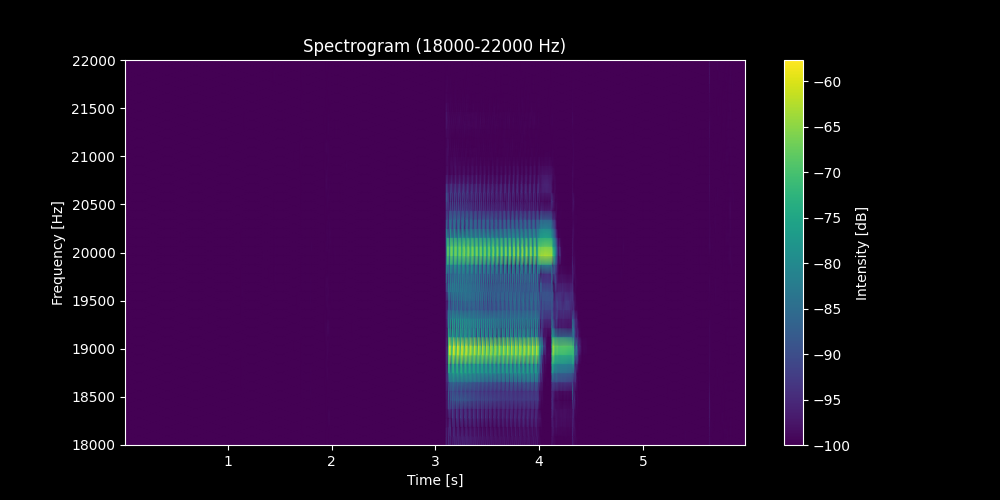

In [10]:
nperseg=1024
noverlap=64
f, t, Sxx = spectrogram(data, fs, nperseg=nperseg, noverlap=noverlap)

# Add a small constant to avoid log of zero
Sxx += 1e-10
plt.style.use('dark_background')
# Plot the spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title(f'Spectrogram ({cutoff_low}-{cutoff_high} Hz)')
plt.colorbar(label='Intensity [dB]')
plt.ylim(cutoff_low, cutoff_high)

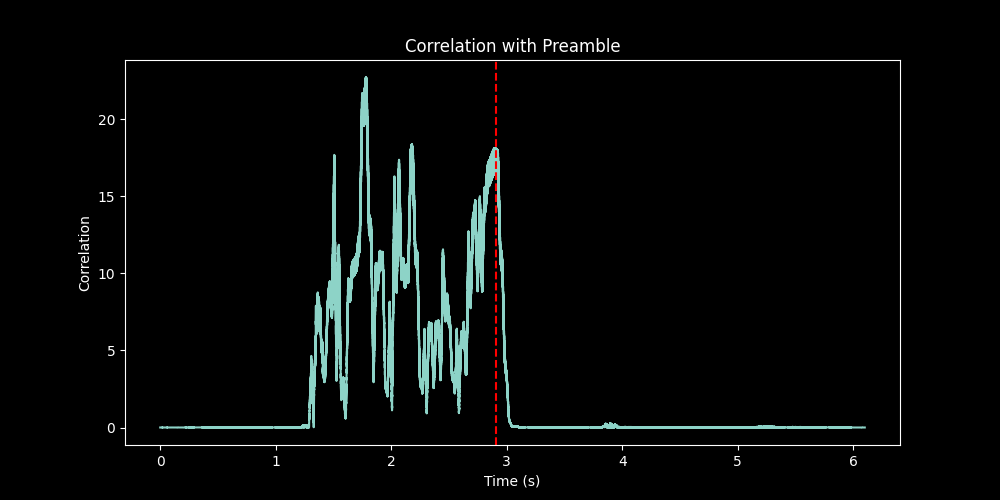

In [15]:
plt.clf()
window_size = 10
# arr = np.convolve(start_corr, np.ones(window_size)/window_size, mode='valid')
arr = savgol_filter(start_corr,window_size,3)
plt.plot(np.arange(len(arr))/fs, np.abs(arr))

# arr = np.flip(arr)
peaks, _ = find_peaks(arr,width = bit_duration*fs/2)

index = peaks[0]
# index = len(arr) - index
plt.axvline(x=index/fs, color='r', linestyle='--', label='Average Correlation')

plt.title('Correlation with Preamble')
plt.xlabel('Time (s)')
plt.ylabel('Correlation')
plt.show()
